# Time series Forecasting of Energy Consumption using machine learning techniques

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Conv1D, Conv1DTranspose, Bidirectional, LSTM, GRU,Lambda,Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pd.options.mode.chained_assignment = None 


In [33]:
df=pd.read_csv("./PJME_hourly.csv",index_col='Datetime')
df.index=pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


# Feature Eng and splitting data 

In [165]:
df['year']=df.index.year
df['quarter']=df.index.quarter
df['month']=df.index.month
df['weekofyear'] = df.index.isocalendar().week
df['dayofyear']=df.index.dayofyear
df['dayofmonth']=df.index.day
df['dayofweek']=df.index.dayofweek
df['day']=df.index.day
df['hour']=df.index.hour

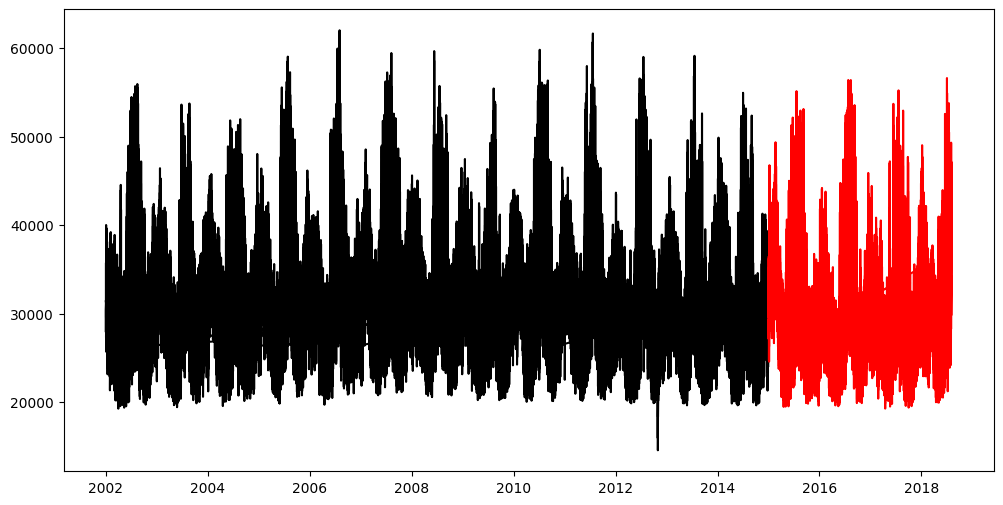

In [166]:
train=df.iloc[df.index < '01-01-2015'] 
test=df.iloc[df.index >= '01-01-2015'] 
plt.figure(figsize=(12, 6))
plt.plot(train["PJME_MW"], color="black")
plt.plot(test["PJME_MW"], color="red")

<Axes: xlabel='hour', ylabel='PJME_MW'>

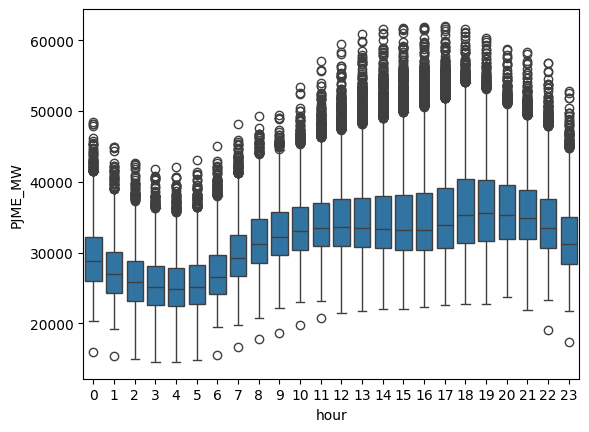

In [167]:
sns.boxplot(x=df["hour"], y=df["PJME_MW"])

<Axes: xlabel='month', ylabel='PJME_MW'>

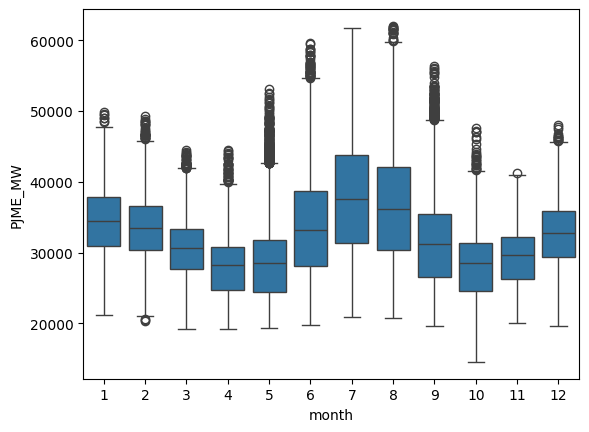

In [168]:
sns.boxplot(x=df["month"], y=df["PJME_MW"])

In [169]:
y_train=train["PJME_MW"]
X_train=train.drop(columns="PJME_MW",axis=1)
y_test=test["PJME_MW"]
X_test=test.drop(columns="PJME_MW",axis=1)

# Model the data with XGBRegressor 

In [170]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:34:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35120	validation_1-rmse:11747.05819
[200]	validation_0-rmse:5836.44568	validation_1-rmse:5362.84878
[300]	validation_0-rmse:3921.88439	validation_1-rmse:4003.42883
[400]	validation_0-rmse:3446.55147	validation_1-rmse:3849.33216
[500]	validation_0-rmse:3286.83297	validation_1-rmse:3813.39212
[600]	validation_0-rmse:3202.19463	validation_1-rmse:3781.93118
[700]	validation_0-rmse:3146.56966	validation_1-rmse:3768.42786
[800]	validation_0-rmse:3107.49011	validation_1-rmse:3752.56429
[900]	validation_0-rmse:3075.84491	validation_1-rmse:3743.15767
[999]	validation_0-rmse:3048.20472	validation_1-rmse:3731.98641


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [171]:
ypred_train=model.predict(X_train)
ypred_test=model.predict(X_test)

print("Train_eval: RMSE, MAE, R2_score")
print(np.sqrt(mean_squared_error(ypred_train,y_train)), mean_absolute_error(ypred_train,y_train), r2_score(ypred_train,y_train))
print("Test_eval: RMSE, MAE, R2_score")
print(np.sqrt(mean_squared_error(ypred_test,y_test)), mean_absolute_error(ypred_test,y_test), r2_score(ypred_test,y_test))

Train_eval: RMSE, MAE, R2_score
3048.4933797054996 2249.7648978798466 0.6732773943248307
Train_eval: RMSE, MAE, R2_score
3731.967095667625 2894.7564998558764 0.47860889519998917


<BarContainer object of 9 artists>

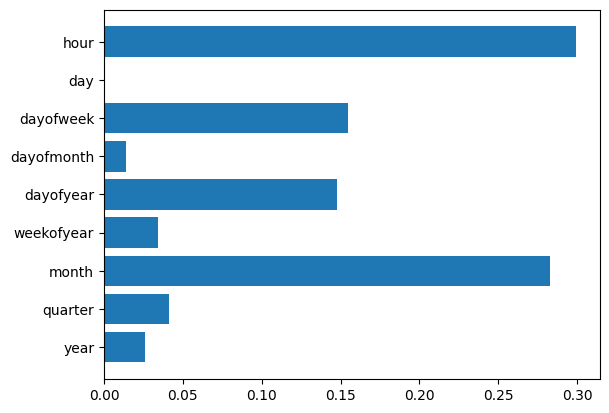

In [172]:
plt.barh(X_train.columns,model.feature_importances_)

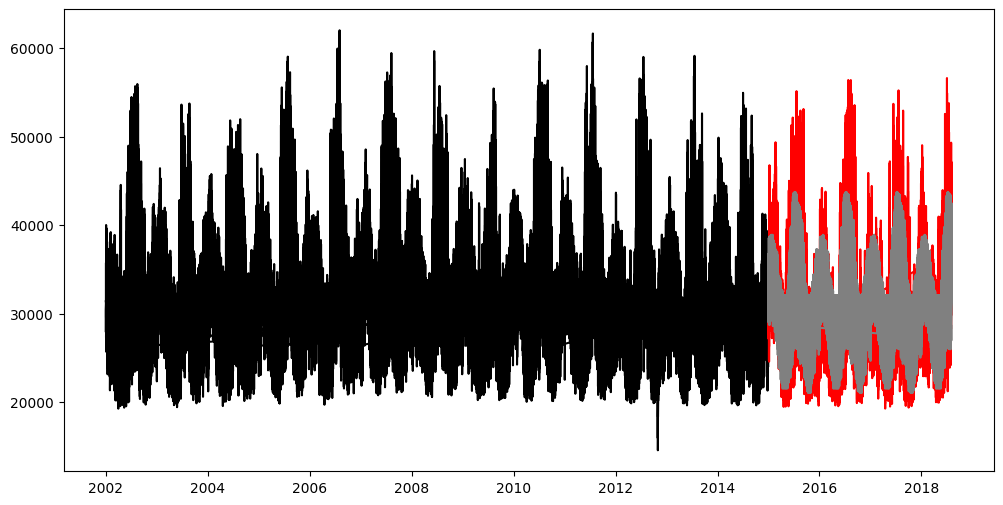

In [173]:
test['prediction']=model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(train["PJME_MW"], color="black")
plt.plot(test["PJME_MW"], color="red")
plt.plot(test['prediction'], color="gray")


In [174]:
test['error']=np.abs(test["PJME_MW"]-test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12969.431966
2016-08-14    12877.854818
2015-02-20    10981.057292
2016-09-09    10806.743001
2016-09-10    10762.612061
2018-01-06    10550.944336
2016-08-12    10170.598145
2015-02-21     9822.061686
2018-01-07     9733.535889
2015-02-16     9610.636149
Name: error, dtype: float64

# Model the data with Dense Neural Network (DNN)

In [34]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [35]:
train_data=df.iloc[df.index < '01-01-2015'] 
test_data=df.iloc[df.index >= '01-01-2015']  

train_dataset=windowed_dataset(train_data,window_size=24, batch_size=32, shuffle_buffer=1000)
test_dataset=windowed_dataset(test_data,window_size=24, batch_size=32, shuffle_buffer=1000)

In [42]:
model_dense = Sequential([ 
        Dense(24,input_shape=[24],activation='relu'),
        Dense(48,activation='relu'),
        Dropout(0.2),
        Dense(24,activation='relu'),
        Dense(1)
]) 
model_dense.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 24)                600       
                                                                 
 dense_71 (Dense)            (None, 48)                1200      
                                                                 
 dropout_49 (Dropout)        (None, 48)                0         
                                                                 
 dense_72 (Dense)            (None, 24)                1176      
                                                                 
 dense_73 (Dense)            (None, 1)                 25        
                                                                 
Total params: 3001 (11.72 KB)
Trainable params: 3001 (11.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
model_dense.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=6e-4),
                  metrics=["mae"])


history=model_dense.fit(train_dataset, epochs=5,validation_data=test_dataset)

Epoch 1/5
3560/3560 [==============================] - 24s 7ms/step - loss: 1888.7838 - mae: 1889.2838 - val_loss: 7002.3457 - val_mae: 7002.8457
Epoch 2/5
3560/3560 [==============================] - 26s 7ms/step - loss: 1044.2549 - mae: 1044.7549 - val_loss: 6190.0713 - val_mae: 6190.5708
Epoch 3/5
3560/3560 [==============================] - 25s 7ms/step - loss: 859.1254 - mae: 859.6252 - val_loss: 6340.5640 - val_mae: 6341.0635
Epoch 4/5
3560/3560 [==============================] - 27s 8ms/step - loss: 760.8644 - mae: 761.3643 - val_loss: 5686.2729 - val_mae: 5686.7729
Epoch 5/5
3560/3560 [==============================] - 21s 6ms/step - loss: 699.6956 - mae: 700.1954 - val_loss: 6163.9775 - val_mae: 6164.4775


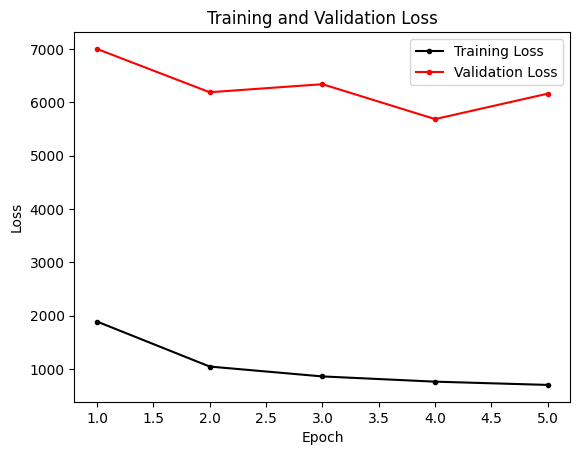

In [44]:
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')

# Plotting loss (if both training and validation losses are available)
plt.plot(np.arange(1, len(train_loss) + 1), train_loss, label='Training Loss', marker=".",c="black")
plt.plot(np.arange(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker=".",c="red")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [45]:
ypred=model_dense.predict(test_dataset)
RMSE = np.sqrt(mean_squared_error(test_data.iloc[24:]["PJME_MW"].to_numpy(), ypred))
mae = mean_absolute_error(test_data.iloc[24:]["PJME_MW"].to_numpy(), ypred)
print(RMSE,mae)

982/982 [==============================] - 4s 4ms/step
9683.069890366673 7719.544832257299


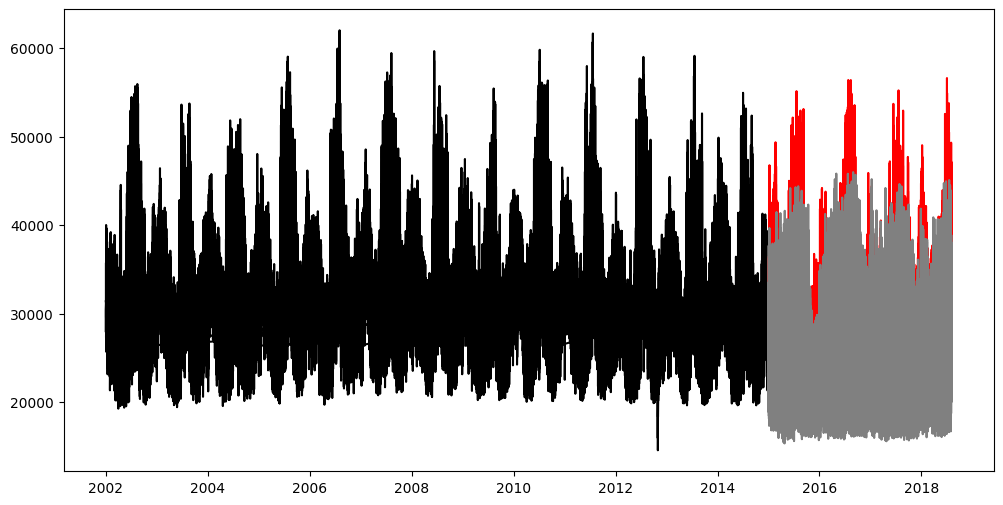

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(train_data["PJME_MW"], color="black")
plt.plot(test_data["PJME_MW"], color="red")
plt.plot(test_data.iloc[24:].index.to_numpy(),ypred, color="gray")

# Autoencoder model

In [47]:
def autoencoder_model(input_dim,first_layer_size,n_downsampling_steps):
    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(first_layer_size, activation="relu")(input_layer)

    # downsampling (encoder) layers
    for n in range(1, n_downsampling_steps):
        encoder = Dense(int(first_layer_size / (2 ** n)), activation="relu")(encoder)

    # upsampling (decoder) layers
    decoder = Dense(int(first_layer_size / (2 ** (n_downsampling_steps - 1))), activation="relu")(encoder)
    for n in reversed(range(0, n_downsampling_steps - 1)):
        decoder = Dense(int(first_layer_size / (2 ** n)), activation="relu")(decoder)

    # Make final autoencoder model
    decoder = Dense(1, activation="sigmoid")(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    return autoencoder

In [48]:
model = autoencoder_model(input_dim=24, first_layer_size=24, n_downsampling_steps=3)
model.summary()
model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=6e-4),
                  metrics=["mae"])
#history=model.fit(train_dataset, epochs=5,validation_data=test_dataset)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 24)]              0         
                                                                 
 dense_74 (Dense)            (None, 24)                600       
                                                                 
 dense_75 (Dense)            (None, 12)                300       
                                                                 
 dense_76 (Dense)            (None, 6)                 78        
                                                                 
 dense_77 (Dense)            (None, 6)                 42        
                                                                 
 dense_78 (Dense)            (None, 12)                84        
                                                                 
 dense_79 (Dense)            (None, 24)                312 

# LSTM model

In [49]:
model = Sequential([
        Conv1D(filters=64, kernel_size=3,strides=1,activation='relu',padding='causal',
                               input_shape=[None,1]),
        LSTM(64,return_sequences=True),
        LSTM(64),
        Dense(64,activation='relu'),
        Dense(32,activation='relu'),
        Dense(1),
    ]) 

In [50]:
model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=6e-4),
                  metrics=["mae"])
model.summary()
history=model.fit(train_dataset, epochs=5,validation_data=test_dataset)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, None, 64)          256       
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_81 (Dense)            (None, 64)                4160      
                                                                 
 dense_82 (Dense)            (None, 32)                2080      
                                                                 
 dense_83 (Dense)            (None, 1)                 33        
                                                                 
Total params: 72577 (283.50 KB)
Trainable params: 725

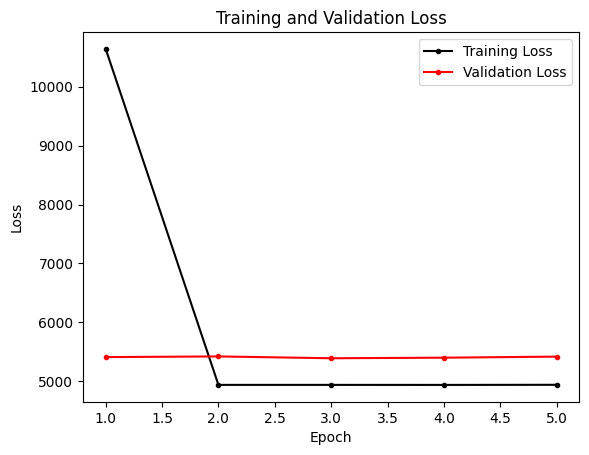

In [53]:
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')

# Plotting loss (if both training and validation losses are available)
plt.plot(np.arange(1, len(train_loss) + 1), train_loss, label='Training Loss', marker=".",c="black")
plt.plot(np.arange(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker=".",c="red")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [64]:
model = Sequential([  
        Input(shape=(24,)),
        Lambda(lambda x: tf.expand_dims(x, axis=-1)),
        Bidirectional(LSTM(32,return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(1),
        Lambda(lambda x: x*100)
        
    ]) 
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_12 (Lambda)          (None, 24, 1)             0         
                                                                 
 bidirectional_12 (Bidirect  (None, 24, 64)            8704      
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, 64)                24832     
 ional)                                                          
                                                                 
 dense_94 (Dense)            (None, 1)                 65        
                                                                 
 lambda_13 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 336

In [65]:
model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=6e-4),
                  metrics=["mae"])

history=model.fit(train_dataset, epochs=5,validation_data=test_dataset)

Epoch 1/5
3560/3560 [==============================] - 104s 27ms/step - loss: 24108.7637 - mae: 24109.2402 - val_loss: 16105.4990 - val_mae: 16106.0107
Epoch 2/5
3560/3560 [==============================] - 82s 23ms/step - loss: 10731.9238 - mae: 10732.4102 - val_loss: 5504.9888 - val_mae: 5505.4888
Epoch 3/5
3560/3560 [==============================] - 82s 23ms/step - loss: 5145.6123 - mae: 5146.1211 - val_loss: 5028.7949 - val_mae: 5029.2949
Epoch 4/5
3560/3560 [==============================] - 83s 23ms/step - loss: 4937.4800 - mae: 4937.9824 - val_loss: 5028.6802 - val_mae: 5029.1802
Epoch 5/5
3560/3560 [==============================] - 83s 23ms/step - loss: 4937.9102 - mae: 4938.4248 - val_loss: 5030.3740 - val_mae: 5030.8745


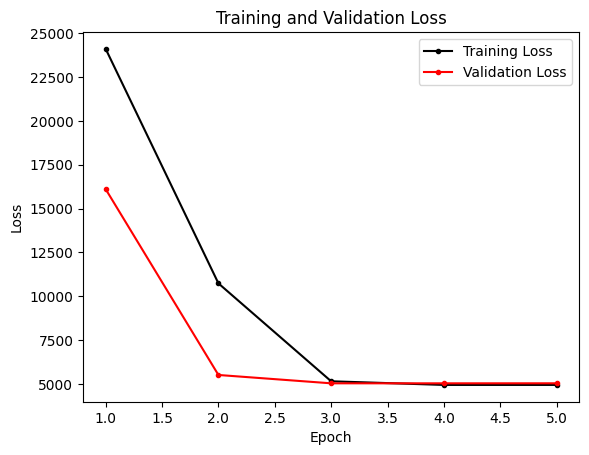

In [66]:
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')

# Plotting loss (if both training and validation losses are available)
plt.plot(np.arange(1, len(train_loss) + 1), train_loss, label='Training Loss', marker=".",c="black")
plt.plot(np.arange(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker=".",c="red")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Conv1D and Conv1DTranspose model

In [51]:
# Define the model
model = Sequential([
        Conv1D(
            filters=64, kernel_size=7, padding="same", strides=2, activation="relu",input_shape=[None,1]
        ),
        Dropout(rate=0.2),
        Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1DTranspose(
            filters=64, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        Dense(128, activation='relu'),  
        Dropout(rate=0.2),
        Dense(64,activation='relu'),
        Dropout(rate=0.2),
        Dense(32,activation='relu'),
        Dense(1, activation='relu')
    ])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, None, 64)          512       
                                                                 
 dropout_50 (Dropout)        (None, None, 64)          0         
                                                                 
 conv1d_29 (Conv1D)          (None, None, 32)          14368     
                                                                 
 dropout_51 (Dropout)        (None, None, 32)          0         
                                                                 
 conv1d_30 (Conv1D)          (None, None, 16)          3600      
                                                                 
 conv1d_transpose_24 (Conv1  (None, None, 16)          1808      
 DTranspose)                                                     
                                                     

In [52]:
model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=6e-4),
                  metrics=["mae"])
#history=model.fit(train_dataset, epochs=5,validation_data=test_dataset)